# Frequency Multiplexing: Transmitting Multiple Voice Signals 
**Objectives:** 
* Show how signals can be moved to different frequencies and combined for transmission
* Show how the combined signals can be separated in the frequency domain
* Explain how this is used in wireless communications

**Required Materials**
* Computer speakers
* Python audio libraries noted below


## Loading the Necessary Libraries

Run each of the cells below, until you get to the  block titled **Frequency Multiplexing: Part 1- Low Pass Filtering**. In  most cases, you can run a cell and advance to the next cell by clicking on the cell and pressing shift-Enter on the keyboard. The triangular "play" button in the widgets bar at the top of the notebook can also be used to run a selected cell.

In [1]:
# These are the minimum sound libraries required. 

import scipy.io.wavfile as wavfile
import sounddevice as sd

In [2]:
# Library for visualizing the sound recordings

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Helper libraries

import numpy as np
import time


In [4]:
# The code in this block loads some elements for adding interactive 
# widgets to the code

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import IPython.display as display



In [5]:
# This notebook uses a couple of new function from SciPy

from scipy.signal import periodogram, butter, sosfilt

In [6]:
# This notebook uses a couple of new functions from NumPy to transform a signal into a frequency
# representation

import numpy.fft

## Frequency Multiplexing: Part 1 -- Low Pass Filtering

*Multiplexing* is a process by which multiple communication signals are combined to use a single medium. Depending on the nature of the signals, they may be multiplexed across time, frequency, or through other approaches. 

In this section, we apply frequency-domain techniques to multiplex voice signals. In this approach, different voice signals are moved to different parts of the frequency range. When the different signals correspond to different users, this approach is called *frequency-division multiple access (FDMA)*. FDMA was used in analog cellular communication systems, but the audio signals were multiplexed by placing the signals in different radio frequency (RF) bands.

In this lab, we will place the signals in different audio bands, so that we can hear the effects of multiplexing. To do this, we will need to limit the audio signals bandwidth so that we can combine multiple audio signals within the same audio frequency  band. We start by demonstrating that voice signals can be truncated to a much lower frequency band than the human ear can hear and then use that fact to limit the frequency range that will be preserved.

First, load two voice signals to work with, by running the following cell:

In [7]:
rate1, voice1 = wavfile.read('testing.wav')
rate2, voice2 = wavfile.read('quickbrownfox.wav')

Now, let's listen to each signal and use the periodogram to plot its power by frequency band:

In [8]:
sd.play(voice1, rate1)

In [9]:
f1, P1 = periodogram(voice1, rate1)

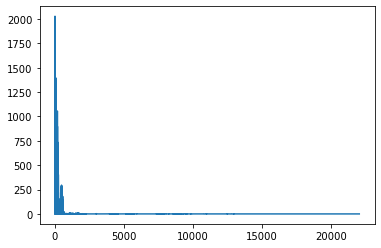

In [10]:
plt.plot(f1,P1)

In [11]:
sd.play(voice2, rate2)

In [12]:
f2, P2 = periodogram(voice2, rate2)

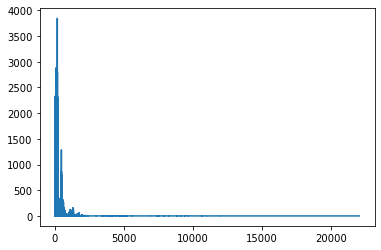

In [13]:
plt.plot(f2, P2)

Note that most of the power in these signals is contained in the lower frequencies of the human hearing range. We can use *low pass filtering* to remove signal components that are at higher frequencies.

In this lab, we will use a very simple approach to remove all the high-frequency content. We will transform the signal into the frequency domain using something called the fast Fourier transform (FFT). You don't need to know the details of how the FFT works -- you just need to know that it captures **all** the information about the signal, but in a frequency-domain version.

If we plot absolute values of the FFT (with a shift to center it), the output of the FFT looks like a two-sided version of the periodogram output. (Don't worry about what negative frequency means for this function -- just know that the negative part will always be symmetric with the positive part for real signals.)

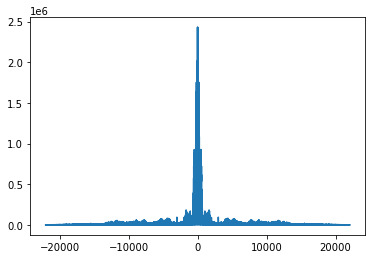

In [14]:
fft1 = numpy.fft.fft(voice1)
freqs1 = numpy.fft.fftfreq(len(voice1), 1/rate1)
plt.plot(freqs1, abs((fft1)))

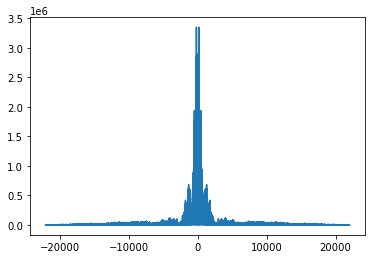

In [15]:
fft2 = numpy.fft.fft(voice2)
freqs2 = numpy.fft.fftfreq(len(voice1), 1/rate2)
plt.plot(freqs2, abs((fft2)))

We can remove the high-frequency information by zeroing it out. The use landline telephone system, which is also called Plain Old Telephone Service (POTS), uses a cutoff of 3.4 KHz for the audio signals, so let's do the same. The parameter `cutoff` below is set to 3400. After completing the activities in this notebook, feel free to come back and change the value of `cutoff` to see the effects of different choices of this parameter:

In [16]:
cutoff = 3400

The following will plot a line showing which frequencies fall below `cutoff` with the `voice1` signal:

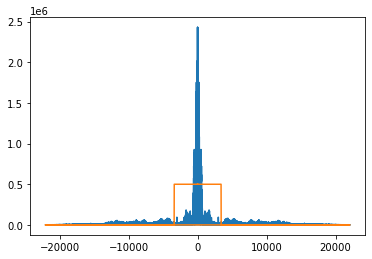

In [17]:
fft1 = numpy.fft.fft(voice1)
freqs1 = numpy.fft.fftfreq(len(voice1), 1/rate1)
plt.plot(freqs1, abs((fft1)))
plt.plot(freqs1, 500000 * (abs(freqs1) <= cutoff) )

Now run the following blocks to zero out all frequencies  over `cutoff`. This block will also remove the value at 0 Hz because that is an offset that does not affect the sound and makes interpreting the signals easier later.  Listen to the signals before and after the high frequencies are removed:

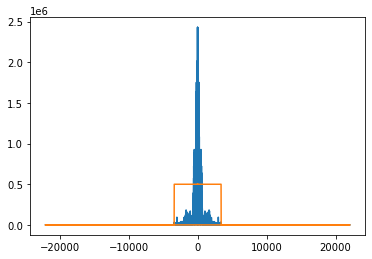

In [18]:
filtered1 = fft1.copy()
filtered1[np.where(abs(freqs1) > cutoff)] = 0
filtered1[0]=0
plt.plot(freqs1, abs(filtered1) )
plt.plot(freqs1, 500000 * (abs(freqs1) <= cutoff) )

In [19]:
np.real(np.fft.ifft(filtered1))

array([68.66915756, 78.77836954, 88.36411128, ..., 46.10416973,
       51.53658226, 59.25522149])

In [20]:
print('Original "testing" voice signal:')
sd.play(voice1)
time.sleep(3)
print('Filtered "testing" signal:')
voice_filtered1 = np.real( np.fft.ifft(filtered1)/16384 )
sd.play(voice_filtered1)


Original "testing" voice signal:
Filtered "testing" signal:


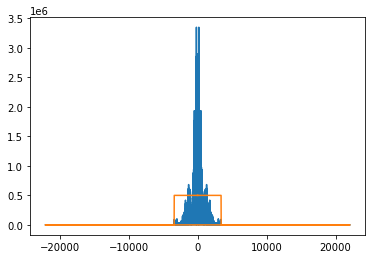

In [21]:
filtered2 = fft2.copy()
filtered2[np.where(abs(freqs2) > cutoff)] = 0
plt.plot(freqs2, abs(filtered2) )
plt.plot(freqs2, 500000 * (abs(freqs2) <= cutoff) )

In [23]:
print('Original "quick brown fox" voice signal:')
sd.play(voice2)
time.sleep(3)
print('Filtered "quick brown fox" signal:')
voice_filtered2 = np.real( np.fft.ifft(filtered2)/16384 )
sd.play(voice_filtered2)


Original "quick brown fox" voice signal:
Filtered "quick brown fox" signal:


**Question 3.1: How do the filtered signals sound in comparison to the original signals?**

## Frequency Multiplexing: Part 2 -- Frequency Shifting and Combining

To multiplex two low-pass signals (i.e., signals with no frequency content above some cutoff frequency) into a single signal in the audio frequencies, we can leave on signal at frequencies < cutoff and shift the other signal so that all of its audio content is above the cutoff. 

POTS uses a separation of 4 kHz, so that is what we will do here as well. Let's leave the `filtered_voice1` signal alone  -- we say that it is at **baseband**, which means that its frequency content starts at 0 Hz. 

Now let's create a shifted version of the `filtered_voice2` signal by shifting its fft content. The approach wee will use it to move all of the frequency components (positive and negative) up to 8 kHz. 8kHz is chosen because the shifted signal will now go from 8-3.4 = 4.6 kHz to 8+3.4= 11.4 kHz,
thus not interfering with the original signal. 

When we shift the signal up to 8 kHz, we also have to shift its mirror image down by 8 kHz to preserve the symmetry.

**NOTE 1:** You might wonder why we don't just shift the right half of the original signal up by 4 kHz and the left half of the original signal down by 4 kHz. That would work as well, **but the new signal would not sound anything like the original voice signal.**

**NOTE 2:** This is *frequency shifting*, not *pitch shifting*. In pitch shifting, the *multiplicative* relation among tones is preserved. By adding a frequency shift, the multiplicative relation between tones is broken, thereby distorting the original pitch relations.

To perform the shift, we need to know the index of 8 kHz in the original frequency data:

In [24]:
np.where(freqs2>8000)

(array([23963, 23964, 23965, ..., 66045, 66046, 66047]),)

A 8 kHz shift corresponds to a shifting the values in the FFT block by 23963. I will set the parameter `freq_shift` to 11982. When you complete this notebook, you can come back and experiment with  different values of `freq_shift`.

In [25]:
freq_shift=23963

The following code will do the necessary shifting. Again, don't worry about the details -- the data in the FFT blocks is arranged in an usual way, and this code will do the necessary shifting. 

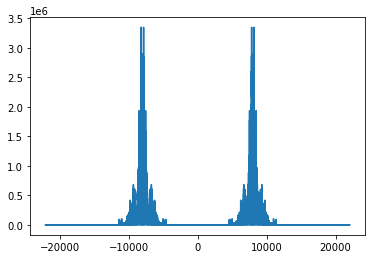

In [26]:
shifted2 = np.roll(filtered2, freq_shift)
shifted2+= np.roll(filtered2[::], -freq_shift-1 )

plt.plot(freqs2, abs(shifted2) )

**Note:** In practice, frequency shifting is not done this way. In fact, frequency shifting is even easier because it just involves multiplying by a sinusoid (a pure tone) and then filtering out low frequency content. The method used here is to keep everything in the frequency domain so that the shifting is more easily understood.

Listen to the frequency-shifted (**not pitch-shifted**) signal

In [30]:

voice_shifted2=np.real(np.fft.ifft(shifted2))/500

sd.play(voice_shifted2)


**Question 3.2: Describe how the frequency-shifted signal sounds compared to the original signal.**

Answers will vary. It will be higher pitch, but it will also sound tiny or electronic.

The code below plots the filtered signal and its frequency-shifted counterpart. 


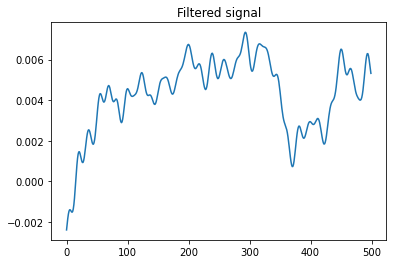

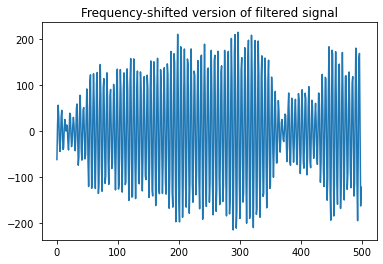

In [31]:
start=10000
length=500

plt.plot(voice_filtered2[start: start+length])
plt.title('Filtered signal')

plt.figure()
voice_shifted2=np.real(np.fft.ifft(shifted2))
plt.plot(voice_shifted2[start: start+length])
plt.title('Frequency-shifted version of filtered signal');


**Question 3.3: How does the plot of the frequency-shifted signal compare to the plot of the original signal?**

The frequency-shifted signal has much faster variations, but the shape of the variations follow the changes in the original signal.

Now the filtered `voice1` signal and the `shifted2`, which is the filtered and frequency-shifted version of the `voice2` signal occupy completely different frequency bands:

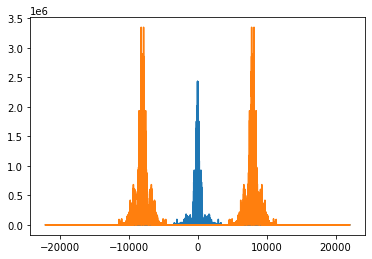

In [32]:
plt.plot(freqs1, abs(filtered1) )
plt.plot(freqs2, abs(shifted2) )

We can combine the two signals into one through simple addition:

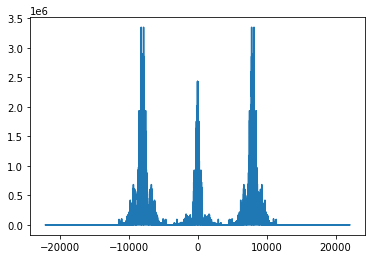

In [33]:
multiplexed = filtered1 + shifted2
plt.plot(freqs1, abs(multiplexed) )

**Activity 3.4:  Listen to the combined signal. Can you hear the different messages? Propose an explanation for what you have heard.**

Answers will vary. Most students should be able to hear both signals. Because the signals occupy different frequency bands, they do not interfere with each other, and our ears can "pull them apart".

In [34]:
voice_multiplexed = np.real( numpy.fft.ifft(multiplexed)/4096 )
sd.play(voice_multiplexed)

## Frequency Demultiplexing

Demultiplexing is the process of recovering the individual signals from a multiplexed signal. We will use FFT again, so that we can see the process in the frequency domain. However, in practice, these techniques are usually implemented using different signal processing techniques.

To recover the signal at baseband (the "testing" signal), we just need to zero out all the higher frequency content:

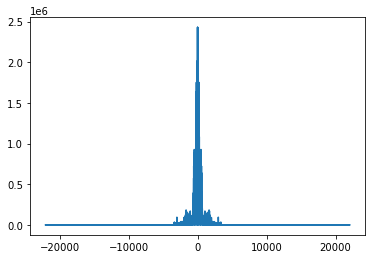

In [39]:
high_freqs = np.where(abs(freqs1)>4000)
demultiplexed1 = multiplexed.copy()
demultiplexed1[high_freqs]=0
plt.plot(freqs1, abs(demultiplexed1) );

To get the voice signal back from the FFT, we apply the IFFT:

In [40]:
voice_demultiplexed1 = np.real(numpy.fft.ifft(demultiplexed1)/16384 )
sd.play(voice_demultiplexed1)

We can recover the "quick brown fox" signal from either the upper frequency band or the lower frequency band. Let's just zero out everything except the uppper frequency band and then shift that band back to the original frequency range:

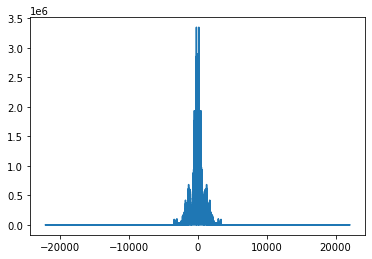

In [41]:
demultiplexed2 = multiplexed.copy()
low_freqs = np.where(freqs1 < 4000) # Note that we are not using abs() here because we zero out
                                    # ALL negative frequencies
demultiplexed2[low_freqs] = 0

# Now shift back to baseband (centered at 0)
demultiplexed2 = np.roll(demultiplexed2, -freq_shift)

plt.plot(freqs1, abs(demultiplexed2) )


In [42]:
voice_demultiplexed2 = np.real(numpy.fft.ifft(demultiplexed2)/16384 )
sd.play(voice_demultiplexed2)

**Questions 3.5: Do you hear any differences between the demultiplexed signals and the filtered signals?  Why do you think you did/did not?**

The signals should sound the same. Because the two signals occupied different frequency bands, they did not interfere with each other and thus could be recovered perfectly.

## Review

* Frequency-division multiplexing is a way to put multiple signals on different, non-overlapping frequency bands
* The FFT and IFFT are techniques to transform signals into frequency representations, where filtering out frequencies or shifting frequencies are easily done
* Demultiplexing is the process of recovering the individual signals that have been multiplexed together.
